# Support Vector Machines Classification

In [1]:
# Start Fresh

%reset -f

In [2]:
# Imports and Set Options

import csv  # for slang
import os
import re  # regex
import string  # punct
from pprint import pprint

import emoji  # for emoji
import gensim
import keras
import lightgbm as lgb
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from gensim.models import Word2Vec
from IPython.display import Image
from matplotlib import pyplot as plt
from nltk.corpus import stopwords  # stopwords
from nltk.stem import PorterStemmer  # stemming
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn import svm, tree
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
                              GradientBoostingClassifier,
                              RandomForestClassifier, RandomForestRegressor,
                              StackingClassifier)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (accuracy_score, auc, average_precision_score,
                             brier_score_loss, classification_report,
                             confusion_matrix, f1_score, fbeta_score,
                             make_scorer, plot_precision_recall_curve,
                             precision_recall_curve, precision_score,
                             recall_score, roc_auc_score, roc_curve)
from sklearn.model_selection import (GridSearchCV, KFold, RandomizedSearchCV,
                                     cross_val_score, train_test_split)
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler
from sklearn.svm import SVC  # "Support vector classifier"
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

# pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline

Using TensorFlow backend.


## Homemade Classes and Functions

In [3]:
# Clean Text Class

class CleanText(BaseEstimator, TransformerMixin):
    
    def remove_mentions(self, input_text):
        '''
        Remove mentions, like @Mplamplampla
        '''
        return re.sub(r'@+', '', input_text)
    
    def remove_urls(self, input_text):
        '''
        Remove the urls mention in a tweet
        '''
        input_text  = ' '.join([w for w in input_text.split(' ') if '.com' not in w])
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        input_text = emoji.demojize(input_text)
        input_text = input_text.replace('_','')
        input_text = input_text.replace(':','')
        return input_text
    
    def possessive_pronouns(self, input_text):
        '''
        Remove the possesive pronouns, because otherwise after tokenization we will end up with a word and an s
        Example: government's --> ["government", "s"]
        '''
        return input_text.replace("'s", "")
    
    def characters(self, input_text):
        '''
        Remove special and redundant characters that may appear on a tweet and that don't really help in our analysis
        '''
        input_text = input_text.replace("\r", " ") # Carriage Return
        input_text = input_text.replace("\n", " ") # Newline
        input_text = " ".join(input_text.split()) # Double space
        input_text = input_text.replace('"', '') # Quotes
        return input_text
    
    def remove_punctuation(self, input_text):
        '''
        Remove punctuation and specifically these symbols '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
        '''
        punct = string.punctuation # string with all the punctuation symbols '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    
    def remove_digits(self, input_text):
        '''
        Remove numbers
        '''
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        '''
        Convert all the sentences(words) to lowercase
        '''
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        '''
        Remove stopwords (refers to the most common words in a language)
        '''
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        '''
        Reduce the words to their stem
        '''
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def encode_decode(self, input_text):
        '''
        Remove weird characters that are result of encoding problems
        '''
        return  " ".join([k.encode("ascii", "ignore").decode() for k in input_text.split(" ")])
    
    
    def translator(self, input_text):
        '''
        Transform abbrevations to normal words
        Example: asap --> as soon as possible
        '''
        input_text = input_text.split(" ")
        j = 0
        for _str in input_text:
            # File path which consists of Abbreviations.
            fileName = r"slang.txt"
            # File Access mode [Read Mode]
            accessMode = "r"
            with open(fileName, accessMode) as myCSVfile:
                # Reading file as CSV with delimiter as "=", so that 
                # abbreviation are stored in row[0] and phrases in row[1]
                dataFromFile = csv.reader(myCSVfile, delimiter="=")
                # Removing Special Characters.
                _str = re.sub('[^a-zA-Z0-9-_.]', '', _str)
                for row in dataFromFile:
                    # Check if selected word matches short forms[LHS] in text file.
                    if _str.upper() == row[0]:
                        # If match found replace it with its appropriate phrase in text file.
                        input_text[j] = row[1]
                myCSVfile.close()
            j = j + 1
        
        return(' '.join(input_text))
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = (X.apply(self.translator)
                    .apply(self.remove_mentions)
                    .apply(self.remove_urls)
                    .apply(self.emoji_oneword)
                    .apply(self.possessive_pronouns)
                    .apply(self.remove_punctuation)
                    .apply(self.remove_digits)
                    .apply(self.encode_decode)
                    .apply(self.characters)
                    .apply(self.to_lower)
                    .apply(self.remove_stopwords)
                    .apply(self.stemming))
        return clean_X
    
    def transform_no_stem(self, X, **transform_params):
        clean_X = (X.apply(self.translator)
                    .apply(self.remove_mentions)
                    .apply(self.remove_urls)
                    .apply(self.emoji_oneword)
                    .apply(self.possessive_pronouns)
                    .apply(self.remove_punctuation)
                    .apply(self.remove_digits)
                    .apply(self.encode_decode)
                    .apply(self.characters)
                    .apply(self.to_lower)
                    .apply(self.remove_stopwords))
        return clean_X

## Read in Data and Create Train and Test Sets

In [4]:
# Read in data (Raw copy for reference; copy for processing)

tweets_raw = pd.read_csv('https://github.com/anilkeshwani/StatLearnProj/raw/master/Iason/climate_change_tweets_sample-2020-05-16-17-57.csv')
tweets = pd.read_csv('https://github.com/anilkeshwani/StatLearnProj/raw/master/Iason/climate_change_tweets_sample-2020-05-16-17-57.csv')
tweets.head()

,username,user_handle,date,retweets,favorites,text,label
0,WWF Climate & Energy,climateWWF,2020-04-28,11,22,Economic recovery and national climate pledges...,0
1,WWF Climate & Energy,climateWWF,2020-04-22,6,16,"In this difficult time, it’s hard to connect w...",0
2,WWF Climate & Energy,climateWWF,2020-04-01,43,69,"The decision to postpone # COP26, is unavoidab...",0
3,WWF Climate & Energy,climateWWF,2020-03-30,24,30,Japan - the world’s fifth largest emitter of g...,0
4,WWF Climate & Energy,climateWWF,2020-03-30,22,40,How can countries include # NatureBasedSolutio...,0


## Clean Dataset

Applies the class methods (leveraging `sklearn` API):

- translator
- remove_mentions
- remove_urls
- emoji_oneword
- possessive_pronouns
- remove_punctuation
- remove_digits
- encode_decode
- characters
- to_lower
- remove_stopwords
- stemming (via Porter Algorithm)

In [5]:
# Text Cleaning

# ct = CleanText()
# tweets["text"] = ct.fit_transform(tweets.text)
# tweets.to_csv("clean_tweets.csv") # save once processed
tweets = pd.read_csv("clean_tweets.csv") # read in instead
tweets = tweets.loc[(~tweets.text.isnull()), :]

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(tweets.text, tweets.label, 
                                                    test_size=0.2, random_state=17, 
                                                    shuffle=True) # explicit default

[print(dat.head(3), dat.shape, end="\n"*2) for dat in [X_train, X_test, Y_train, Y_test]];

3642     might progress climat area not enough global s...
12695    trump crackdown politic scienc nasa climat div...
8451     no one would believ human panick fals climat m...
Name: text, dtype: object (14406,)

8376     nazi root environment climat chang fraud bbcne...
6111     interest democrat candid compar mani aspect cl...
13983    ittrademark imposs see global warm signal minn...
Name: text, dtype: object (3602,)

3642     0
12695    1
8451     1
Name: label, dtype: int64 (14406,)

8376     1
6111     0
13983    1
Name: label, dtype: int64 (3602,)



In [7]:
print(f"Training label counts: \n{Y_train.value_counts()}", end="\n"*2)
print(f"Test label counts: \n{Y_test.value_counts()}")

Training label counts: 
1    8433
0    5973
Name: label, dtype: int64

Test label counts: 
1    2138
0    1464
Name: label, dtype: int64


In [8]:
# Save set of workspace objects' names to enable periodic clean-up

necessities = set(dir())

## Word Vectorisations

### Bag of Words (BOW) Binary ("One-Hot") Representation

In [9]:
# Bag of Words Representation (One Hot, i.e. binary)

BOW_vectorizer = CountVectorizer(stop_words = 'english', 
                                 binary=True, # Creates 0/1 "One Hot" vector; 
                                              # np.unique(BOW_train.toarray())
                                 min_df = 10)
BOW_vectorizer.fit(X_train)
BOW_train = BOW_vectorizer.transform(X_train)
BOW_test = BOW_vectorizer.transform(X_test)

In [10]:
# Most frequently occurring words in the training corpus

[(index, word) for index, word in sorted(BOW_vectorizer.vocabulary_.items(), key=lambda item: item[1], reverse=True)][:20]

[('zero', 2206),
 ('yr', 2205),
 ('youtub', 2204),
 ('youthvgov', 2203),
 ('youthtopow', 2202),
 ('youthclimatesummit', 2201),
 ('youth', 2200),
 ('young', 2199),
 ('york', 2198),
 ('yesterday', 2197),
 ('year', 2196),
 ('yeah', 2195),
 ('ye', 2194),
 ('yall', 2193),
 ('yale', 2192),
 ('ya', 2191),
 ('wwf', 2190),
 ('wsj', 2189),
 ('wrote', 2188),
 ('wrong', 2187)]

### Bag of Words with Frequencies Representation (FBOW)

In [11]:
# Bag of Words Representation (Frequencies; binary=False)

FBOW_vectorizer = CountVectorizer(stop_words = 'english', 
                                  binary=False, # Creates Word Frequency Vector; 
                                                # # np.unique(FBOW_train.toarray())
                                  min_df = 10)
FBOW_vectorizer.fit(X_train)
FBOW_train = FBOW_vectorizer.transform(X_train)
FBOW_test = FBOW_vectorizer.transform(X_test)

In [12]:
# Word use (per tweet) frequencies

print(np.unique(FBOW_train.toarray(), return_counts=True))

# Feature_Index: Word Mapping

# {v: k for k, v in FBOW_vectorizer.vocabulary_.items()}

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 13], dtype=int64), array([31661370,   127070,     5161,      379,       45,        7,
              5,        1,        2,        1,        1], dtype=int64))


### Term Frequency–Inverse Document Frequency Representation (tf-idf)

In [13]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', 
                                   min_df=10) # used for now for consistency
tfidf_vectorizer.fit(X_train)
tfidf_train = tfidf_vectorizer.transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

#### Reminder: Available objects produced by `fit`

Manual inspection of the attributes added after `fit`ting is useful; these are identified with a trailing underscore, e.g. `Cs_` or `scores_`

The `score_` attribute is a dictionary with one entry per outcome class; in our binary case, only the class `1` is stored in the dictionary. 

Each entry has dimension `(n_folds, n_cs, n_l1_ratios)`; i.e.  `(n_arrays, n_rows, n_cols)`. 

In [14]:
# objects produced by fit

# print("Fit Objects:")

# for item in dir(sklearn_Estimator):
#     if item.endswith("_") and (not item.startswith("_")):
#         print(item)

### Random Forests: BOW Representation

In [92]:
rf_clf = RandomForestClassifier(oob_score=True)

rf_clf.fit(BOW_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [93]:
rf_clf_cv_score = cross_val_score(rf_clf, BOW_train, Y_train)

print(f"Training Set Accuracy: {rf_clf.score(BOW_train, Y_train)}")
print(f"Out-of-Bag Score: {rf_clf.oob_score_}")

print(f"Cross-validated accuracy : {rf_clf_cv_score}") 
print(f"Mean CV accuracy : {np.round(np.mean(rf_clf_cv_score), 3)}")

print(f"Test set score : {rf_clf.score(BOW_test, Y_test)}")

Training Set Accuracy: 0.9991670137442732
Out-of-Bag Score: 0.887477439955574
Cross-validated accuracy : [0.89486468 0.88510934 0.88823325 0.88233252 0.88198542]
Mean CV accuracy : 0.887
Test set score : 0.8861743475846752


### Hyper-parameter Tuning via Grid Search

In [22]:
# Hyper-parameter Tuning via Grid Search

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 100, 120],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}

# Set Cross-Validation Process

kfcv = KFold(n_splits=5, shuffle=True, random_state=101)

# Instantiate the grid search model
rf_grid_search = GridSearchCV(estimator = rf_clf, param_grid = param_grid, 
                              cv = kfcv, n_jobs = -1, verbose = 2)

In [64]:
rf_grid_search.fit(BOW_train, Y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 17.1min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=101, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_f...
                                              n_estimators=100, n_jobs=None,
                                              oob_score=True, rando

In [89]:
# Best Score

print(f"Best Score: {rf_grid_search.best_score_}", end="\n"*2)

# Best Parameters

print("Best parameters:")
for k, v in rf_grid_search.best_params_.items():
    print(str(k) + ": " + str(v))

Best Score: 0.8864362242175818

Best parameters:
bootstrap: True
max_depth: 120
max_features: log2
min_samples_leaf: 1
min_samples_split: 12
n_estimators: 300


### Random Forests: FBOW Representation

In [94]:
rf_clf_FBOW = RandomForestClassifier(oob_score=True)

rf_clf_FBOW.fit(FBOW_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [95]:
rf_clf_FBOW_cv_score = cross_val_score(rf_clf_FBOW, FBOW_train, Y_train)

print(f"Training Set Accuracy: {rf_clf_FBOW.score(FBOW_train, Y_train)}")
print(f"Out-of-Bag Score: {rf_clf_FBOW.oob_score_}")

print(f"Cross-validated accuracy : {rf_clf_FBOW_cv_score}") 
print(f"Mean CV accuracy : {np.round(np.mean(rf_clf_FBOW_cv_score), 3)}")

print(f"Test set score : {rf_clf_FBOW.score(FBOW_test, Y_test)}")

Training Set Accuracy: 0.9992364292655838
Out-of-Bag Score: 0.887963348604748
Cross-validated accuracy : [0.89694656 0.87955571 0.88649774 0.89205137 0.88372093]
Mean CV accuracy : 0.888
Test set score : 0.8850638534147696


### Hyper-parameter Tuning via Grid Search

In [96]:
# Hyper-parameter Tuning via Grid Search

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 100, 120],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}

# Set Cross-Validation Process

kfcv = KFold(n_splits=5, shuffle=True, random_state=101)

# Instantiate the grid search model
rf_grid_search_FBOW = GridSearchCV(estimator = rf_clf_FBOW, param_grid = param_grid, 
                              cv = kfcv, n_jobs = -1, verbose = 2)

In [ ]:
rf_grid_search_FBOW.fit(FBOW_train, Y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   59.3s


In [ ]:
# Best Score

print(f"Best Score: {rf_grid_search_FBOW.best_score_}", end="\n"*2)

# Best Parameters

print("Best parameters:")
for k, v in rf_grid_search_FBOW.best_params_.items():
    print(str(k) + ": " + str(v))

### Random Forests: TF-IDF Representation

In [ ]:
rf_clf_tfidf = RandomForestClassifier(oob_score=True)

rf_clf_tfidf.fit(tfidf_train, Y_train)

In [ ]:
rf_clf_tfidf_cv_score = cross_val_score(rf_clf_tfidf, tfidf_train, Y_train)

print(f"Training Set Accuracy: {rf_clf_tfidf.score(tfidf_train, Y_train)}")
print(f"Out-of-Bag Score: {rf_clf_tfidf.oob_score_}")

print(f"Cross-validated accuracy : {rf_clf_tfidf_cv_score}") 
print(f"Mean CV accuracy : {np.round(np.mean(rf_clf_tfidf_cv_score), 3)}")

print(f"Test set score : {rf_clf_tfidf.score(tfidf_test, Y_test)}")

### Hyper-parameter Tuning via Grid Search

In [ ]:
# Hyper-parameter Tuning via Grid Search

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 100, 120],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}

# Set Cross-Validation Process

kfcv = KFold(n_splits=5, shuffle=True, random_state=101)

# Instantiate the grid search model
rf_grid_search_tfidf = GridSearchCV(estimator = rf_clf_tfidf, param_grid = param_grid, 
                                    cv = kfcv, n_jobs = -1, verbose = 2)

In [ ]:
rf_grid_search_tfidf.fit(tfidf_train, Y_train)

In [ ]:
# Best Score

print(f"Best Score: {rf_grid_search_tfidf.best_score_}", end="\n"*2)

# Best Parameters

print("Best parameters:")
for k, v in rf_grid_search_tfidf.best_params_.items():
    print(str(k) + ": " + str(v))

### Support Vector Machines

#### SVM Linear Model

In [111]:
model_SVM_l1 = SVC(kernel='linear', 
                   C=1, 
                   probability=True)

model_SVM_l1.fit(BOW_train, Y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [112]:
pred_BOW_SVM_linear = model_SVM_l1.predict(BOW_test)
accuracy_BOW_SVM_linear = model_SVM_l1.score(BOW_test, Y_test)
conf_mat_BOW_SVM_linear = confusion_matrix(Y_test, pred_BOW_SVM_linear)
print("Confusion Matrix (Linear SVM):\n", 
      conf_mat_BOW_SVM_linear, '\n', 
      "which corresponds to an accuracy of : ", 
      np.round(accuracy_BOW_SVM_linear, 3))

Confusion Matrix (Linear SVM):
 [[1286  178]
 [ 182 1956]] 
 which corresponds to an accuracy of :  0.9


In [ ]:
model_SVM_l1_CV = GridSearchCV(model_SVM_l1, 
                              param_grid = {"C": np.logspace(start = -10, stop = 10, 
                                                             num = 1, 
                                                             base = 2)})
model_SVM_l1_CV.fit(BOW_train, Y_train)

In [ ]:
for item in dir(model_SVM_l1_CV):
    if item.endswith("_") and (not item.startswith("_")):
        print(item)

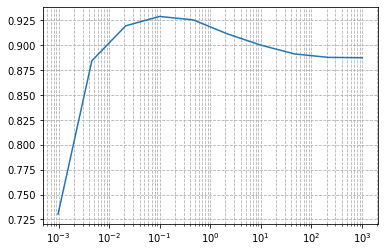

In [15]:
plt.plot(log,cv_score[:,0])
plt.xscale('log')
plt.grid(True, which ="both",linestyle ='--')
plt.show()

In [16]:
best_acc = np.argmax(cv_score[:,0])
best_C = cv_score[best_acc,0] #0.9288911107364795

In [17]:
model_SVM_max = SVC(kernel='linear', C=log[3], probability=True)
model_SVM_max.fit(X_train, Y_train)

SVC(C=0.09921256574801249, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [18]:
y_pred_max = model_SVM_max.predict(X_test)

acc_max = model_SVM_max.score(X_test,Y_test)*100

con_mat = confusion_matrix(Y_test,y_pred_max)

print("The precision of the model is summarize in the following table : ", con_mat, '\n', "which correspond to an accuracy of : ", acc_max)

The precision of the model is summarize in the following table :  [[2232  183]
 [ 236 3292]] 
 which correspond to an accuracy of :  92.94968870940602


### SVM gaussian model

In [20]:
model_SVM_l1_g = SVC(kernel='rbf', C=1, probability = True)
model_SVM_l1_g.fit(X_train, Y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [21]:
y_pred_l1_g=model_SVM_l1_g.predict(X_test)
acc_l1_g = model_SVM_l1_g.score(X_test,Y_test)*100
con_mat_l1_g=confusion_matrix(Y_test,y_pred_l1_g)
print("The precision of the model is summarize in the following table : ", con_mat_l1_g, '\n', "which correspond to an accuracy of : ", acc_l1_g)

The precision of the model is summarize in the following table :  [[2252  163]
 [ 243 3285]] 
 which correspond to an accuracy of :  93.16843345111896


In [22]:
scores_g = cross_val_score(model_SVM_l1_g, X_train, Y_train, cv=5)

In [23]:
log = np.logspace(start = -10,stop = 10, num = 10, base = 2)
cv_score_g=np.zeros((len(log),1))
i=0
for k in log :
    model_SVM_i = SVC(kernel='rbf', C=k)
    scores_i = cross_val_score(model_SVM_i, X_train, Y_train, cv=5)
    cv_score_g[i]=np.mean(scores_i)
    i+=1

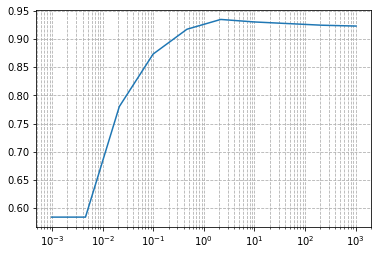

In [24]:
plt.plot(log,cv_score_g[:,0])
plt.xscale('log')
plt.grid(True, which ="both",linestyle ='--')
plt.show()

In [27]:
best_acc_g = np.argmax(cv_score_g[:,0])
best_C_g = cv_score_g[best_acc_g,0]

print(best_acc_g)
print(best_C_g)

5
0.9348583394764137


In [28]:
model_SVM_max_g = SVC(kernel = 'rbf', C = best_acc_g, probability = True)
model_SVM_max_g.fit(X_train, Y_train)

SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [29]:
y_pred_max_g=model_SVM_max_g.predict(X_test)

acc_max_g = model_SVM_max_g.score(X_test,Y_test)*100

con_mat_g=confusion_matrix(Y_test,y_pred_max_g)

print("The precision of the model is summarize in the following table : ",con_mat_g, '\n', "which correspond to an accuracy of : ", acc_max_g)

The precision of the model is summarize in the following table :  [[2256  159]
 [ 215 3313]] 
 which correspond to an accuracy of :  93.70688204610465


### ROC curve to compare our models' accuracy

In [30]:
lin_roc_auc = roc_auc_score(Y_test, model_SVM_l1.predict(X_test))
fpr_lin, tpr_lin, thresholds_lin = roc_curve(Y_test, model_SVM_l1.predict_proba(X_test)[:,1])

g_roc_auc = roc_auc_score(Y_test, model_SVM_l1_g.predict(X_test))
fpr_g, tpr_g, thresholds_g = roc_curve(Y_test, model_SVM_l1_g.predict_proba(X_test)[:,1])

lin_roc_auc_max = roc_auc_score(Y_test, model_SVM_max.predict(X_test))
fpr_lmax, tpr_lmax, thresholds_lmax = roc_curve(Y_test, model_SVM_max.predict_proba(X_test)[:,1])

g_roc_auc_max = roc_auc_score(Y_test, model_SVM_max_g.predict(X_test))
fpr_gmax, tpr_gmax, thresholds_gmax = roc_curve(Y_test, model_SVM_max_g.predict_proba(X_test)[:,1])

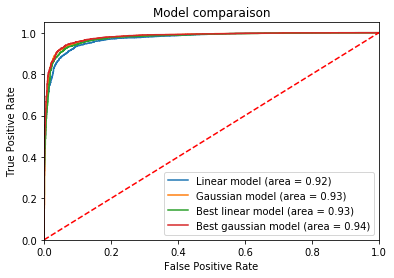

In [31]:
plt.figure()
plt.plot(fpr_lin, tpr_lin, label='Linear model (area = %0.2f)' % lin_roc_auc)
plt.plot(fpr_g, tpr_g, label='Gaussian model (area = %0.2f)' % g_roc_auc)
plt.plot(fpr_lmax, tpr_lmax, label='Best linear model (area = %0.2f)' % lin_roc_auc_max)
plt.plot(fpr_gmax, tpr_gmax, label='Best gaussian model (area = %0.2f)' % g_roc_auc_max)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model comparaison')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Variations coefficients : 

In [33]:
score_lin = cross_val_score(model_SVM_l1, X_train, Y_train, cv = 5, scoring = 'accuracy')
score_best_lin = cross_val_score(model_SVM_max, X_train, Y_train, cv = 5, scoring = 'accuracy')
score_best_gauss = cross_val_score(model_SVM_max_g, X_train, Y_train, cv = 5, scoring = 'accuracy')
score_gauss = cross_val_score(model_SVM_l1_g, X_train, Y_train, cv = 5, scoring = 'accuracy')

In [35]:
name = np.array(['linear model']+['best linear model']+['gaussian model']+['best gaussian model'])
L_2 = [name,np.array([np.mean(score_lin),np.mean(score_best_lin),np.mean(score_gauss),np.mean(score_best_gauss)])]
score_model = pd.DataFrame()
score_model[""], score_model["Score with 5 fold CV"]= [L_2[0],L_2[1]]
print(score_model)

                        Score with 5 fold CV
0         linear model              0.919526
1    best linear model              0.928891
2       gaussian model              0.931958
3  best gaussian model              0.931543
